# Setup

In [4]:
from jax.scipy.stats import norm
from jax import jit
from jax.numpy.fft import fft2, ifft2
from functools import partial
import jax.numpy as jnp

def elliptical_sersic_profile(I_e, r_e, n, x0, y0, x, y, ellip, theta):
    
    # Ellipticity and orientation parameters
    q = 1 - ellip
    theta = jnp.radians(theta)
    
    # Calculate transformed coordinates
    xt = (x - x0) * jnp.cos(theta) + (y - y0) * jnp.sin(theta)
    yt = (y - y0) * jnp.cos(theta) - (x - x0) * jnp.sin(theta)
    
    # Calculate radius
    r = jnp.sqrt(xt ** 2 + (yt / q) ** 2)
    
    # Calculate Sersic profile
    bn = 1.9992 * n - 0.3271  # approximation valid for 0.5 < n < 10
    I = I_e * jnp.exp(-bn * ((r / r_e) ** (1 / n) - 1))
    return I



@partial(jit, static_argnums=(2,))
def pad_and_convolve_fft(x, y, padding=True):
    """
    FFT (Fast Fourier Transform) convolution is performed after an optional padding.

    :param x: first array 
    :param y: second array 
    :param padding: padding
    :type padding: bool

    :return: Output array

    """
    if padding:
        x = jnp.pad(x, ((4, 4), (4, 4)), constant_values=0.)
        y = jnp.pad(y, ((4, 4), (4, 4)), constant_values=0.)

    output = fft_convolve2d(x, y)
    if padding:
        return output[4:-4, 4:-4]
    else:
        return output

@jit
def fft_convolve2d(x, y):
    """ 
    2D convolution using the Fast Fourier Transform (FFT).

    :param x: first 2D array
    :param y: second 2D array

    :return: 2D array 

    """
    fr = fft2(x)
    fr2 = fft2(jnp.flipud(jnp.fliplr(y)))
    m, n = fr.shape
    cc = jnp.real(ifft2(fr * fr2))
    cc = jnp.roll(cc, int(-m / 2), axis=0)
    cc = jnp.roll(cc, int(-n / 2), axis=1)
    return cc


def downsample(image, factor=2):
    """
    Resizes an image from dimensions (nx, ny) to (nx/factor, ny/factor).

    :param image: 2D array with shape (nx, ny)
    :param factor: downsampling factor, which must be greater than or equal to 1
    :type factor: int

    :return: 2D array

    """

    f = int(factor)
    nx, ny = np.shape(image)

    small = image.reshape([int(nx / f), f, int(ny / f), f]).mean(3).mean(1)
    return small * f**2

@jit
def gaussian_psf(x0, y0, A, x, y):
    """Calculate the value of a 2D Gaussian PSF."""
    # fwhm 2
    g = A * norm.pdf(x, loc=x0, scale=0.85) * norm.pdf(y, loc=y0, scale=0.85)
    return g


def create_model_no_galaxy(x1, y1, A1, x2, y2, A2):
    
    psf1 = gaussian_psf(x1, y1, A1, X, Y)
    psf2 = gaussian_psf(x2, y2, A2, X, Y)

    model = psf1 + psf2

    return model


def create_model_with_galaxy(x1, y1, A1, x2, y2, A2, xg, yg, I_e, r_e, n, ellip, theta):
    
    psfs = create_model_no_galaxy(x1, y1, A1, x2, y2, A2)
    
    sersic = elliptical_sersic_profile(I_e, r_e, n, xg, yg, X, Y, ellip, theta)

    model = sersic + psfs

    return model


def down_resolution(model):
    return downsample(pad_and_convolve_fft(model, narrow_psf), 2)

# Fake data

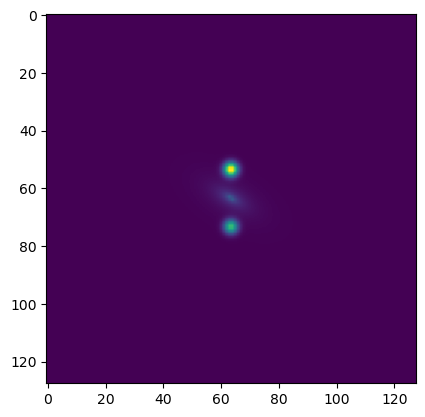

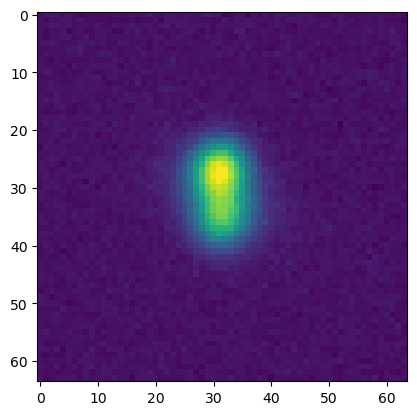

In [74]:
import numpy as np
import matplotlib.pyplot as plt

psf = lambda x,y, x0, y0, A: A*np.exp(-0.05*(x-x0)**2 - 0.05*(y-y0)**2)

# grid of small pixels
X, Y = x, y = np.meshgrid(np.linspace(-32,32, 128), np.linspace(-32,32,128))


narrow_psf = psf(x,y, 0, 0, 1)
narrow_psf /= narrow_psf.sum()

m = create_model_with_galaxy(0, 5, 1, 0, -5, 1.5,    0, 0,     0.01, 5.0, 1.5, 0.5, 30)
plt.imshow(m)
plt.figure()

noise_scale = 0.0015
data = down_resolution(m)
data += np.random.normal(loc=0, scale=noise_scale, size=data.shape)
plt.imshow(data)
noisemap = noise_scale * np.ones_like(data)

# pre-optim

1.0030488


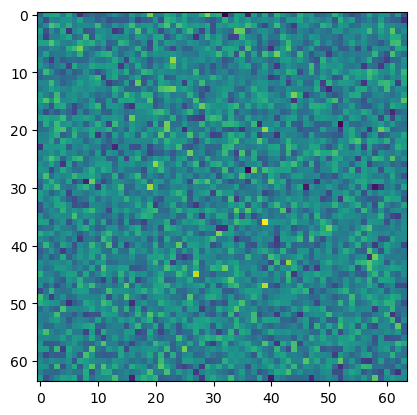

In [75]:
@jit
def residual(params, data, noisemap):
    x1, y1, A1, x2, y2, A2, xg, yg, I_e, r_e, n, ellip, theta = params
    model = create_model_with_galaxy(x1, y1, A1, x2, y2, A2, xg, yg, I_e, r_e, n, ellip, theta)
    model = down_resolution(model)
    return ((model - data) / noisemap).flatten()

from scipy.optimize import least_squares

# Initial parameter guess
params0 = [ 0,  5,     1,       0,      -5,      1.,       0,      0,       0.0,     5.0,     1.5  , 0., 0]
#params0 = [0, y1_init, A1_init, x2_init, y2_init, A2_init, xg_init, yg_init, I_e_init, r_e_init, n_init, ellip_init, theta_init]


res = least_squares(residual, params0, args=(data, noisemap))
residuals = (data - down_resolution(create_model_with_galaxy(*res.x)))/noisemap
chi_squared = np.sum(residuals ** 2)

dof = data.size - len(res.x)

# Compute reduced chi-squared
reduced_chi_squared = chi_squared / dof
print(reduced_chi_squared)
plt.imshow(residuals)

2.5254545


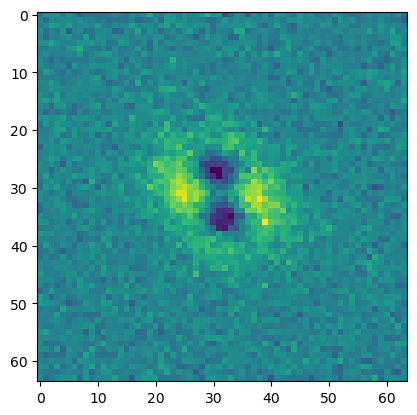

In [77]:
@jit
def residual(params, data, noisemap):
    x1, y1, A1, x2, y2, A2 = params
    model = create_model_no_galaxy(x1, y1, A1, x2, y2, A2)
    model = down_resolution(model)
    return ((model - data) / noisemap).flatten()

from scipy.optimize import least_squares

# Initial parameter guess
params0 = [ 0,  5,     1,       0,      -5,      1.]
res = least_squares(residual, params0, args=(data, noisemap))
residuals = (data - down_resolution(create_model_no_galaxy(*res.x)))/noisemap
chi_squared = np.sum(residuals ** 2)

dof = data.size - len(res.x)

# Compute reduced chi-squared
reduced_chi_squared = chi_squared / dof
print(reduced_chi_squared)
plt.imshow(residuals)

# Sampling

In [15]:
import jax.numpy as jnp
from jax import random
from jax.image import scale_and_translate
import numpyro
import numpyro.distributions as dist
from scipy import interpolate
from numpyro.infer import MCMC, NUTS



# Model
def model(image_data, image_uncertainties, params):
    # Flatten the images
    image_data_flat = image_data.flatten()
    image_uncertainties_flat = image_uncertainties.flatten()
    # this basically allows us to use the numypro.plate context manager
    # below. Not very useful here, but indicates that each pixel
    # is independant. Some samplers can take advantage of this,
    # so let's do it this way.
    
    
    # Unpack optimized parameters
    x1_opt, y1_opt, A1_opt, x2_opt, y2_opt, A2_opt, xg_opt, yg_opt, \
                           I_e_opt, r_e_opt, n_opt, ellip_opt, theta_opt = params
    
    bounds = 5
    # Uniform priors centered around optimized parameters
    x1 = numpyro.sample('x1', dist.Uniform(x1_opt - bounds, x1_opt + bounds))
    y1 = numpyro.sample('y1', dist.Uniform(y1_opt - bounds, y1_opt + bounds))
    A1 = numpyro.sample('A1', dist.Uniform(A1_opt - bounds, A1_opt + bounds))
    
    x2 = numpyro.sample('x2', dist.Uniform(x2_opt - bounds, x2_opt + bounds))
    y2 = numpyro.sample('y2', dist.Uniform(y2_opt - bounds, y2_opt + bounds))
    A2 = numpyro.sample('A2', dist.Uniform(A2_opt - bounds, A2_opt + bounds))

    xg = numpyro.sample('xg', dist.Uniform(xg_opt - bounds, xg_opt + bounds))
    yg = numpyro.sample('yg', dist.Uniform(yg_opt - bounds, yg_opt + bounds))
    I_e = numpyro.sample('I_e', dist.Uniform(0.1*I_e_opt, 10*I_e_opt))
    r_e = numpyro.sample('r_e', dist.Uniform(0.1*r_e_opt, 10*r_e_opt))
    n = numpyro.sample('n', dist.Uniform(0.5, 10))
    ellip = numpyro.sample('ellip', dist.Uniform(0, 0.99))
    theta = numpyro.sample('theta', dist.Uniform(0, 2*np.pi))

    # Model
    model = create_model_with_galaxy(x1, y1, A1, x2, y2, A2, xg, yg, I_e, r_e, n, ellip, theta)
    model = down_resolution(model)

    # Likelihood
    with numpyro.plate('data', len(image_data_flat)):
        numpyro.sample('obs', dist.Normal(model.flatten(), image_uncertainties_flat), obs=image_data_flat)


# Run MCMC
nuts_kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup=300, num_samples=600)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data, noisemap, res.x)
mcmc.print_summary()



sample: 100%|██████████████████████████████████████████████████| 900/900 [01:58<00:00,  7.60it/s, 63 steps of size 7.70e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        A1      1.00      0.01      1.00      0.98      1.03   1141.51      1.00
        A2      1.47      0.02      1.47      1.44      1.50    485.38      1.00
       I_e      0.01      0.00      0.01      0.01      0.01    246.90      1.00
     ellip      0.45      0.05      0.45      0.38      0.53    385.82      1.00
         n      1.60      0.26      1.58      1.23      2.08    323.61      1.00
       r_e      4.89      0.23      4.88      4.52      5.25    254.68      1.01
     theta      5.19      1.01      5.50      3.72      6.27    590.86      1.00
        x1     -0.05      0.07     -0.05     -0.17      0.05    505.30      1.00
        x2     -0.02      0.05     -0.02     -0.10      0.06    606.00      1.00
        xg      0.03      0.09      0.02     -0.13      0.17    576.43      1.00
        y1     15.09      0.07     15.09     14.97     15.21    508.60      1.00
        y2    -10.01      0

In [16]:
import arviz as az

inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 600), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A1,1.003,0.015,0.973,1.029,0.000,0.000,1158.0,517.0,NaN
A2,1.471,0.020,1.435,1.508,0.001,0.001,480.0,369.0,NaN
I_e,0.010,0.001,0.008,0.011,0.000,0.000,247.0,278.0,NaN
ellip,0.455,0.048,0.368,0.543,0.002,0.002,378.0,328.0,NaN
n,1.602,0.260,1.121,2.089,0.014,0.010,338.0,340.0,NaN
r_e,4.890,0.233,4.464,5.316,0.015,0.011,253.0,278.0,NaN
theta,5.193,1.008,3.214,6.278,0.041,0.029,502.0,323.0,NaN
x1,-0.051,0.068,-0.168,0.099,0.003,0.003,505.0,387.0,NaN
x2,-0.016,0.047,-0.103,0.077,0.002,0.002,612.0,371.0,NaN
xg,0.026,0.091,-0.145,0.189,0.004,0.004,624.0,435.0,NaN


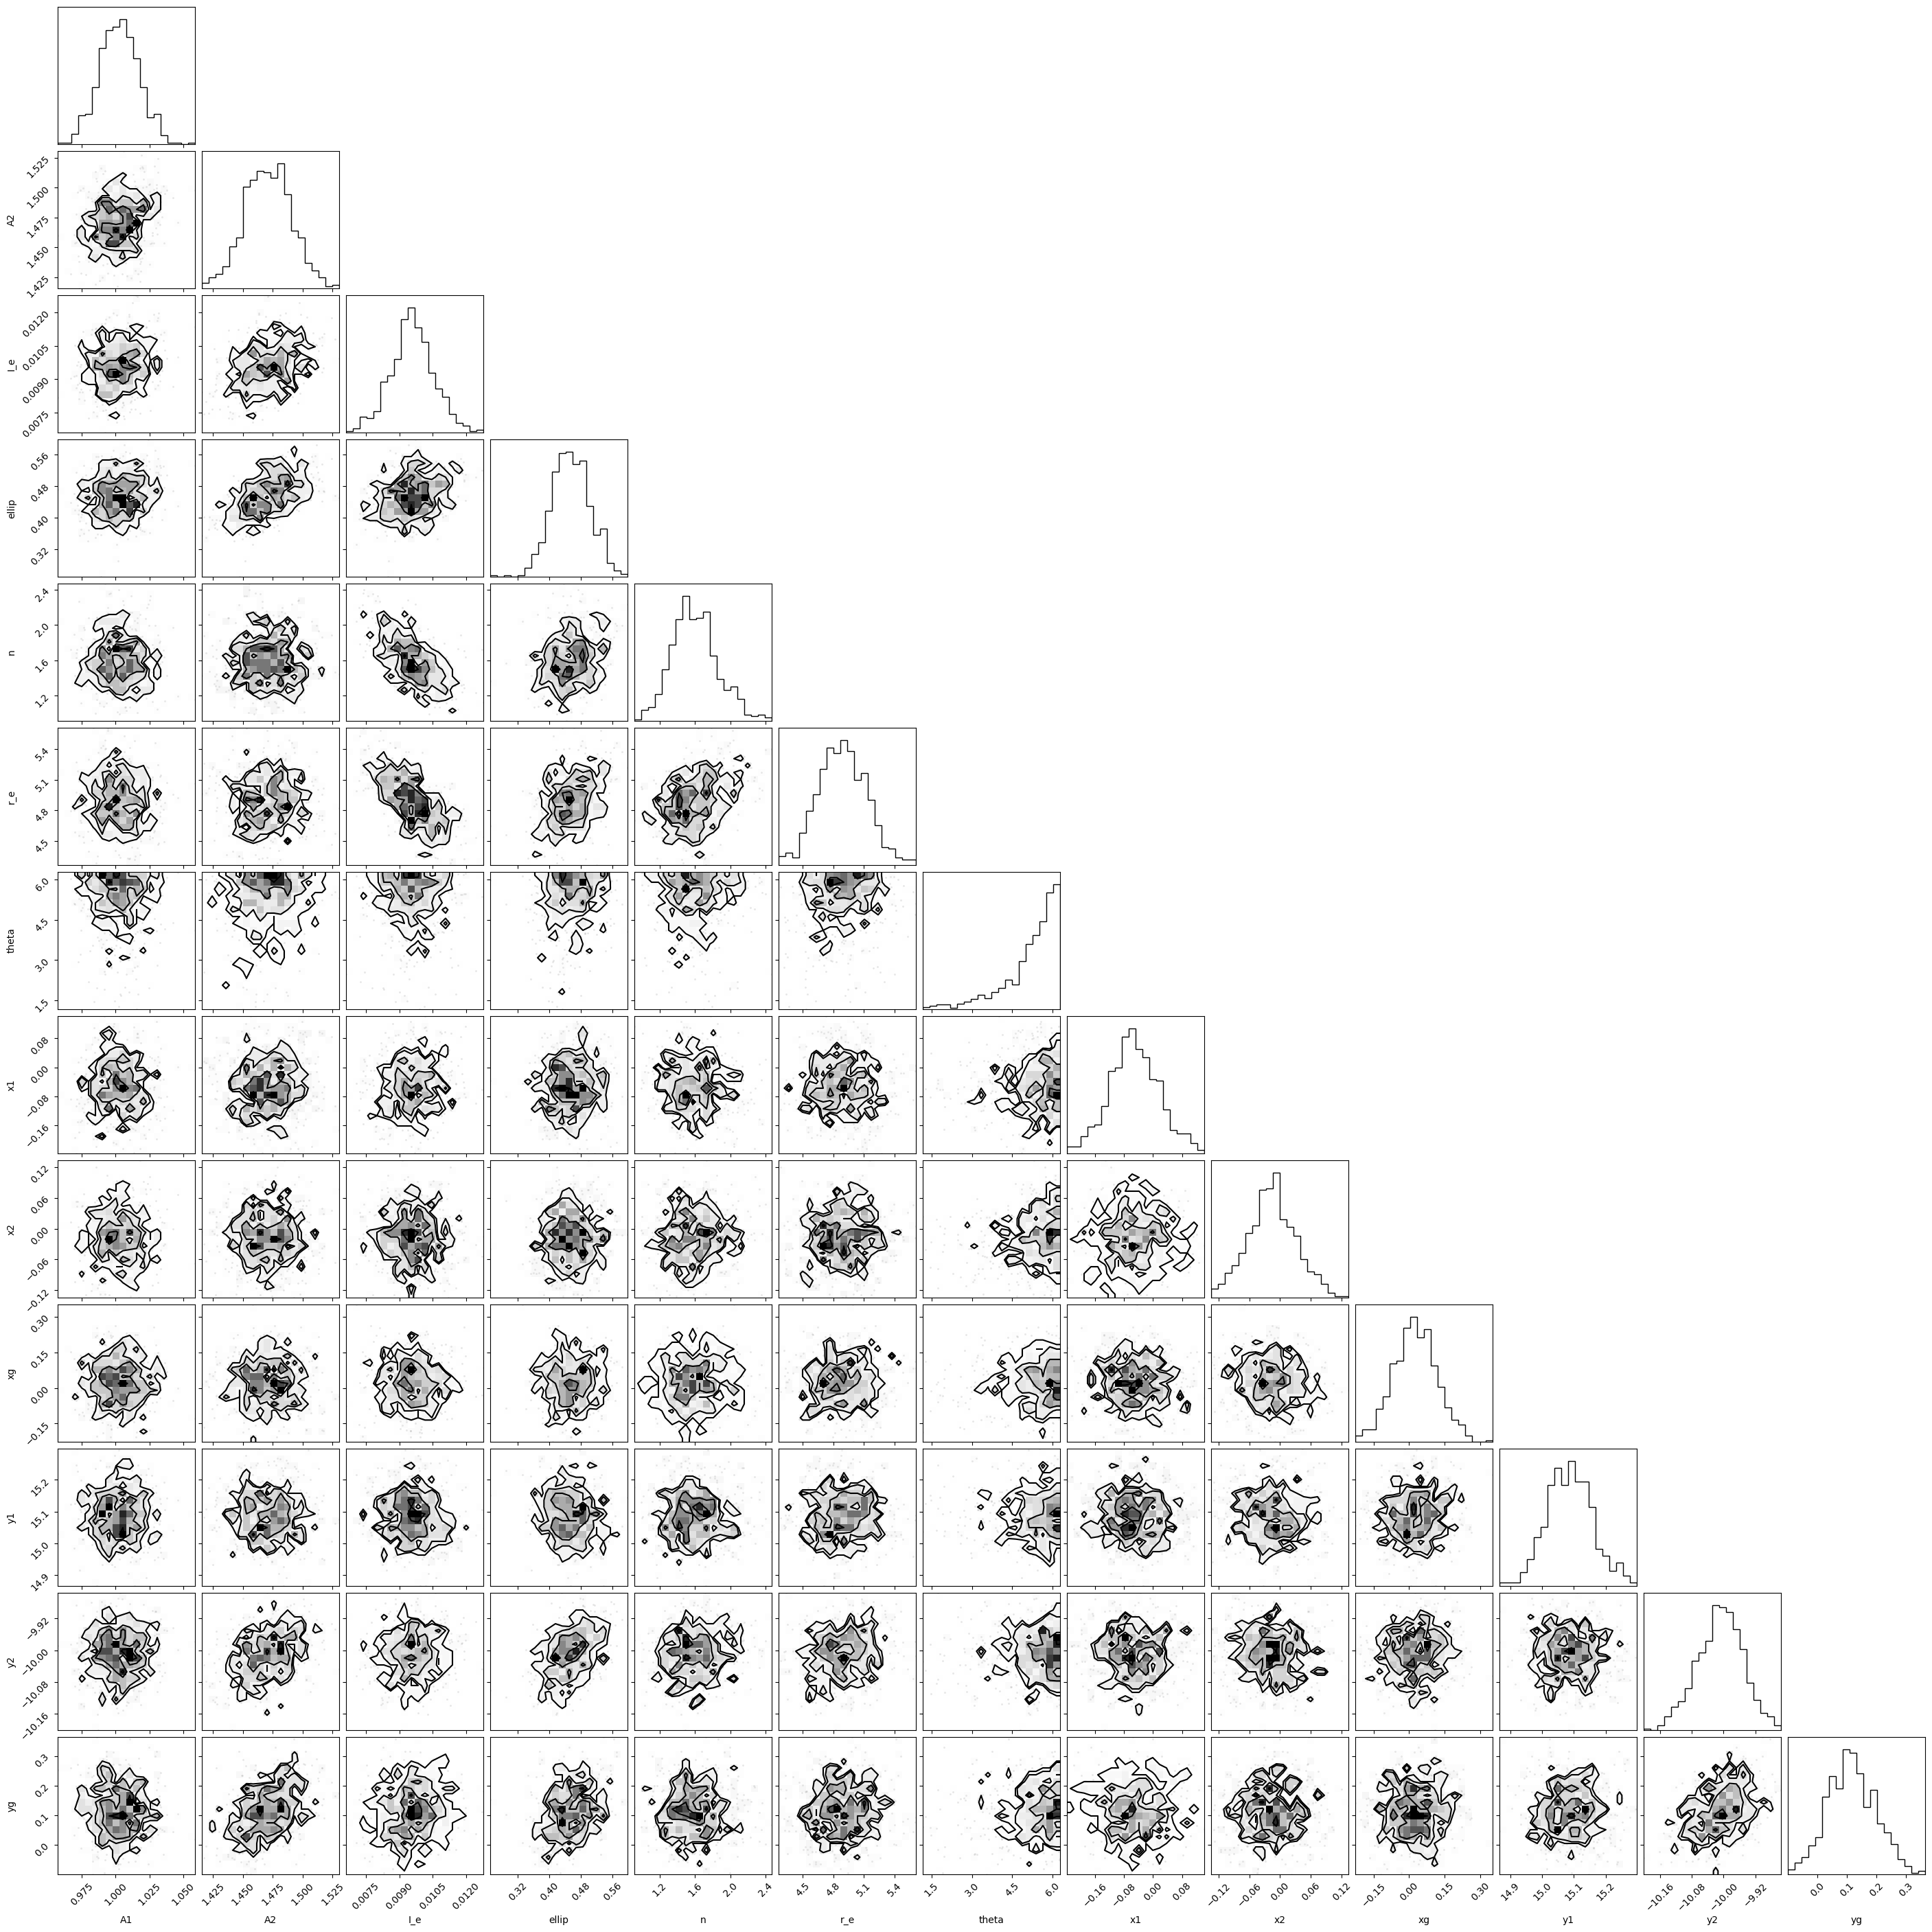

In [17]:
import corner

corner.corner(inf_data);


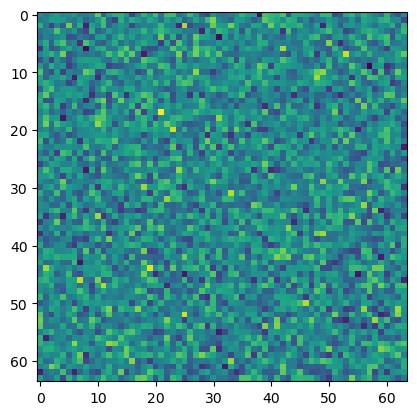

In [22]:
params = {key: np.median(val) for key,val in mcmc.get_samples().items()}

plt.imshow(data - down_resolution(create_model_with_galaxy(**params)))